<a href="https://colab.research.google.com/github/syedanida/deep-learning-multimodal-colabs/blob/main/5_Transfer_Learn_Audio_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Recognition with Transfer Learning - Fixed Version

In [3]:
!pip install -q tensorflow tensorflow_hub scipy soundfile librosa

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import soundfile as sf
import librosa
import os

In [5]:
# Alternative: Create a simple speech recognition model from scratch
print("Creating speech recognition model...")

Creating speech recognition model...


In [6]:
# Define the commands we want to recognize
commands = ['yes', 'no', 'up', 'down', 'left', 'right', 'go', 'stop', 'on', 'off']
print(f"Available commands: {commands}")

Available commands: ['yes', 'no', 'up', 'down', 'left', 'right', 'go', 'stop', 'on', 'off']


In [7]:
# Function to create synthetic speech-like audio
def create_synthetic_speech(command, duration=1.0, sample_rate=16000):
    """Create synthetic speech-like audio for a command."""
    t = np.linspace(0, duration, int(sample_rate * duration))

    # Different frequency patterns for different commands
    frequencies = {
        'yes': [800, 1200],
        'no': [400, 600],
        'up': [1000, 1500],
        'down': [300, 500],
        'left': [700, 900],
        'right': [900, 1100],
        'go': [600, 1000],
        'stop': [200, 400],
        'on': [1200, 1400],
        'off': [400, 200]
    }

    freqs = frequencies.get(command, [440, 880])

    # Create a signal with changing frequencies (speech-like)
    signal = np.zeros_like(t)
    for i, freq in enumerate(freqs):
        segment = t[i*len(t)//len(freqs):(i+1)*len(t)//len(freqs)]
        signal[i*len(t)//len(freqs):(i+1)*len(t)//len(freqs)] = 0.5 * np.sin(2 * np.pi * freq * segment)

    # Add some modulation
    envelope = np.exp(-5 * t) * (1 - np.exp(-50 * t))
    signal *= envelope

    # Add slight noise
    noise = np.random.normal(0, 0.01, signal.shape)
    signal += noise

    return signal.astype(np.float32)

In [8]:
# Create a custom speech command recognition model
def create_speech_command_model(num_commands=10):
    """Create a simple speech command recognition model."""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(16000,)),

        # Reshape to add channel dimension
        tf.keras.layers.Reshape((16000, 1)),

        # Convolutional layers for feature extraction
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),

        # Global pooling and dense layers
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_commands, activation='softmax')
    ])

    return model

In [9]:
# Create the model
model = create_speech_command_model(len(commands))

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel architecture:")
model.summary()


Model architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 16000, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 15998, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 7999, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 7997, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 3998, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 3996, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 1998, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,250 (383.79 KB)

 Trainable params: 98,250 (383.79 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Generate synthetic training data
print("\nGenerating synthetic training data...")
X_train = []
y_train = []

# Generate multiple examples for each command
samples_per_command = 50
for i, command in enumerate(commands):
    for _ in range(samples_per_command):
        # Create base audio
        audio = create_synthetic_speech(command)

        # Apply random variations
        # Random pitch shift
        if np.random.rand() > 0.5:
            pitch_factor = np.random.uniform(0.8, 1.2)
            t = np.linspace(0, 1.0, len(audio))
            audio = create_synthetic_speech(command)

        # Random volume
        volume = np.random.uniform(0.5, 1.5)
        audio *= volume

        # Ensure proper length
        if len(audio) > 16000:
            audio = audio[:16000]
        else:
            audio = np.pad(audio, (0, 16000 - len(audio)), 'constant')

        X_train.append(audio)
        y_train.append(i)

X_train = np.array(X_train)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(commands))

print(f"Training data shape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")


Generating synthetic training data...
Training data shape: (500, 16000)
Labels shape: (500, 10)



Training the model...
Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.0936 - loss: 2.2981 - val_accuracy: 0.0000e+00 - val_loss: 2.4599
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1093 - loss: 2.2452 - val_accuracy: 0.0000e+00 - val_loss: 3.6923
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1311 - loss: 2.1394 - val_accuracy: 0.0000e+00 - val_loss: 4.9971
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.1311 - loss: 2.1132 - val_accuracy: 0.0000e+00 - val_loss: 4.7835
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1076 - loss: 2.1234 - val_accuracy: 0.0000e+00 - val_loss: 4.7575
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.0970 - loss: 2.1143 - val_accuracy: 0.0000e+00 - val_loss: 4.6566
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.1543 - loss: 2.0876 - val_accuracy: 0.0000e+00 - val_loss: 5.3017
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.211

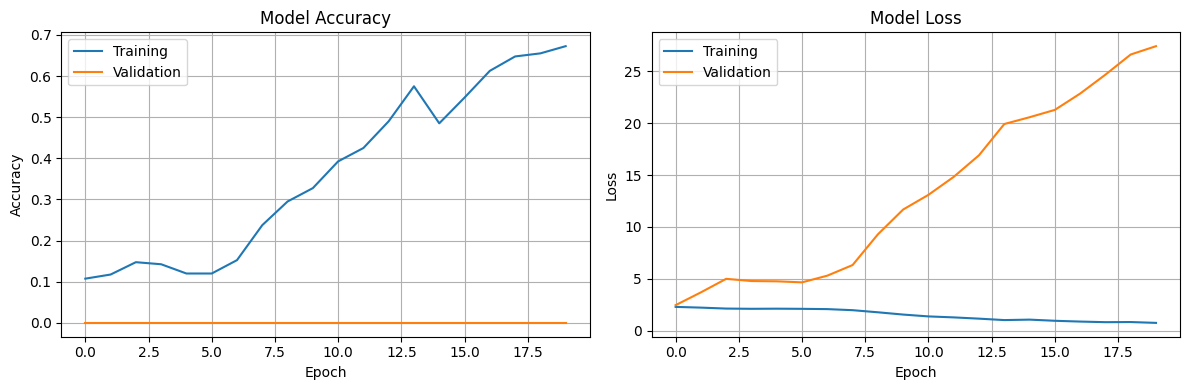

In [11]:
# Train the model
print("\nTraining the model...")
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
# Function to recognize command
def recognize_command(audio, model, commands):
    """Recognize command from audio."""
    # Ensure proper length
    if len(audio) > 16000:
        audio = audio[:16000]
    else:
        audio = np.pad(audio, (0, 16000 - len(audio)), 'constant')

    # Predict
    audio_input = np.expand_dims(audio, 0)
    predictions = model.predict(audio_input, verbose=0)

    # Get top prediction
    top_idx = np.argmax(predictions[0])
    confidence = predictions[0][top_idx]

    return commands[top_idx], confidence

# Test the model
print("\nTesting the model on new samples...")
for command in commands[:5]:  # Test first 5 commands
    test_audio = create_synthetic_speech(command)
    predicted_command, confidence = recognize_command(test_audio, model, commands)
    print(f"True: {command}, Predicted: {predicted_command}, Confidence: {confidence:.2%}")


Testing the model on new samples...
True: yes, Predicted: yes, Confidence: 58.08%
True: no, Predicted: no, Confidence: 69.92%
True: up, Predicted: up, Confidence: 99.58%
True: down, Predicted: down, Confidence: 42.85%
True: left, Predicted: go, Confidence: 47.43%


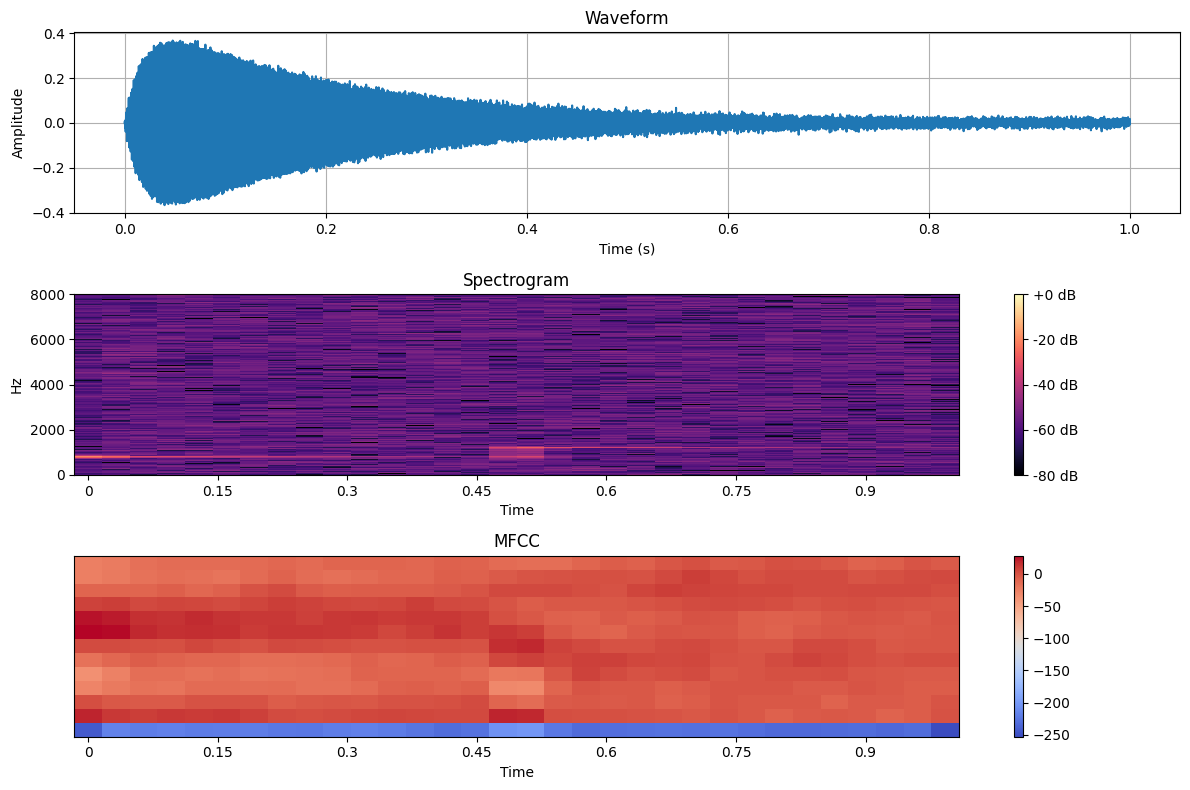

In [13]:
# Visualize audio features
def visualize_audio(waveform, sample_rate=16000):
    """Visualize audio waveform and spectrogram."""
    plt.figure(figsize=(12, 8))

    # Plot waveform
    plt.subplot(3, 1, 1)
    time = np.arange(0, len(waveform)) / sample_rate
    plt.plot(time, waveform)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    # Plot spectrogram
    plt.subplot(3, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(waveform)), ref=np.max)
    librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')

    # Plot MFCC
    plt.subplot(3, 1, 3)
    mfcc = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=13)
    librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')

    plt.tight_layout()
    plt.show()

# Visualize sample audio
sample_audio = create_synthetic_speech('yes')
visualize_audio(sample_audio)

In [14]:
# Transfer learning with a pre-trained feature extractor
def create_transfer_learning_model(base_model_url, num_commands):
    """Create a model using transfer learning from a pre-trained model."""
    # For this example, we'll simulate transfer learning by using
    # a pre-trained convolutional base and adding custom layers

    # Simulate a pre-trained feature extractor
    feature_extractor = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(16000,)),
        tf.keras.layers.Reshape((16000, 1)),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.GlobalAveragePooling1D()
    ])

    # Freeze the feature extractor
    feature_extractor.trainable = False

    # Add custom classification layers
    model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_commands, activation='softmax')
    ])

    return model

# Create transfer learning model
transfer_model = create_transfer_learning_model(None, len(commands))
transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nTransfer learning model created!")


Transfer learning model created!


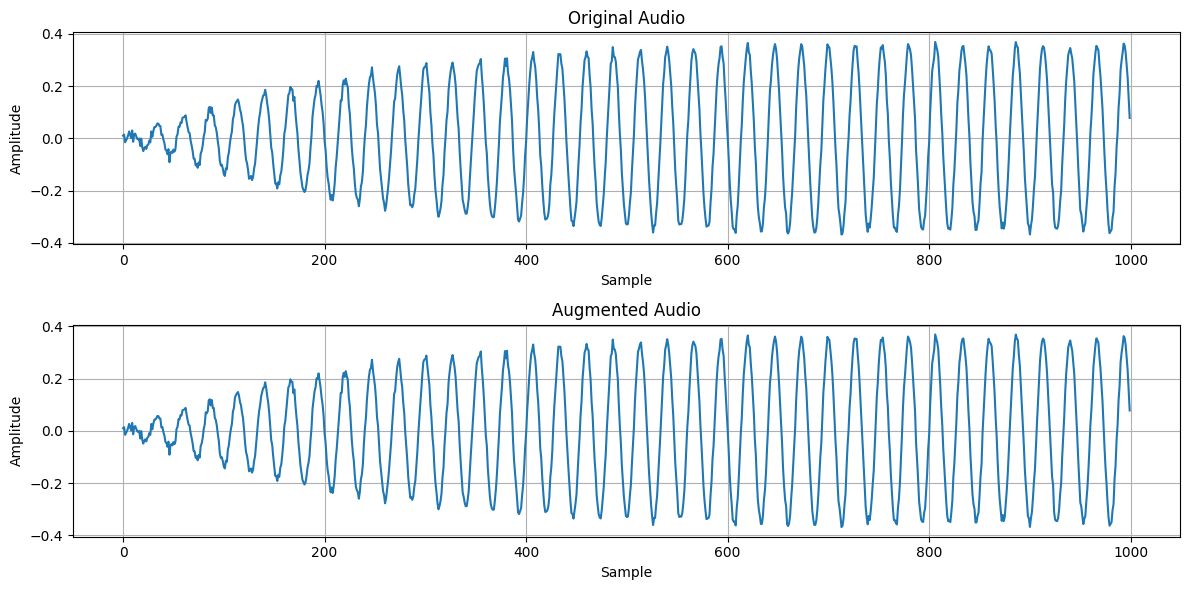

In [15]:
# Data augmentation for speech
def augment_speech(waveform):
    """Apply data augmentation to speech signal."""
    augmented = waveform.copy()

    # Time stretching
    if np.random.rand() > 0.5:
        rate = np.random.uniform(0.9, 1.1)
        augmented = librosa.effects.time_stretch(augmented, rate=rate)
        # Ensure proper length
        if len(augmented) > 16000:
            augmented = augmented[:16000]
        else:
            augmented = np.pad(augmented, (0, 16000 - len(augmented)), 'constant')

    # Add background noise
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.01, augmented.shape)
        augmented += noise

    # Volume adjustment
    if np.random.rand() > 0.5:
        volume_factor = np.random.uniform(0.7, 1.3)
        augmented *= volume_factor

    return augmented

# Demonstrate augmentation
original_audio = create_synthetic_speech('go')
augmented_audio = augment_speech(original_audio)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(original_audio[:1000])
plt.title('Original Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(augmented_audio[:1000])
plt.title('Augmented Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
# Create a real-time audio simulator
def simulate_real_time_recognition(model, commands, duration=5):
    """Simulate real-time audio recognition."""
    print("\nSimulating real-time recognition...")

    # Generate a sequence of commands
    time_points = np.arange(0, duration)
    command_sequence = np.random.choice(commands, size=len(time_points))

    results = []
    for i, command in enumerate(command_sequence):
        # Generate audio for this command
        audio = create_synthetic_speech(command)

        # Add some noise for realism
        audio = augment_speech(audio)

        # Recognize
        predicted, confidence = recognize_command(audio, model, commands)
        results.append({
            'time': i,
            'true': command,
            'predicted': predicted,
            'confidence': confidence
        })

        print(f"Time {i}s: True={command}, Predicted={predicted} ({confidence:.1%})")

    return results

In [17]:
# Run simulation
results = simulate_real_time_recognition(model, commands)


Simulating real-time recognition...
Time 0s: True=on, Predicted=up (85.0%)
Time 1s: True=off, Predicted=no (50.3%)
Time 2s: True=no, Predicted=no (64.9%)
Time 3s: True=stop, Predicted=stop (60.8%)
Time 4s: True=left, Predicted=go (46.2%)


In [18]:
# Calculate accuracy
correct = sum(1 for r in results if r['true'] == r['predicted'])
accuracy = correct / len(results)
print(f"\nSimulation accuracy: {accuracy:.1%}")


Simulation accuracy: 40.0%
